In [ ]:
from google.colab import drive
import os
from PIL import Image
import cv2
import pandas as pd
import numpy as np
import scipy
import random
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Javascript, display, Markdown, clear_output

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


!pip install Augmentor
import Augmentor

RANDOM = 42
random.seed(RANDOM)

In [ ]:
import pickle

def save(obj, file):
    pickle.dump(obj, open(SAVE + file ,'wb')) # SAVE is global variable for directory 

def save_csv(obj, file):
  if isinstance(obj, np.ndarray):
    pd.DataFrame(obj).to_csv(SAVE + file, index=False, header=False)
  elif isinstance(obj, (pd.Series, pd.DataFrame)):
    obj.to_csv(SAVE + file, index=False, header=True) # SAVE is global variable for directory

def save_txt(obj, file):
  with open(file, 'w') as f:
      f.writelines(obj)

def load_csv(file):
    return pd.read_csv(SAVE + file).to_numpy()

def load(file):
    return pickle.load(open(SAVE + file, 'rb'))

def RMSE(pred, truth):
    # Element-wise RMSE score. 
    return np.sqrt( np.mean( np.square( np.array(pred).flatten() - np.array(truth).flatten() )))

### Mounting Google Drive

In [ ]:
%%capture

# display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

# Mount Google Drive and load Kaggle API key into environment. 
# You'll have to customize this step for yourself. 
drive.mount('/content/gdrive', force_remount=True)
FOLDERNAME = '/content/gdrive/My Drive/Colab\ Notebooks/'
os.environ['KAGGLE_CONFIG_DIR'] = FOLDERNAME

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Jun 19 16:11:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
# The data is directories of jpg images. A lot of them. 
!mkdir /content/processed_64x64
!mkdir /content/processed_128x128
DIR_64 = '/content/processed_64x64/'
DIR_128 = '/content/processed_128x128/'
!mkdir /content/processed_64x64_WIDE
!mkdir /content/processed_128x128_WIDE
DIR_64_WIDE = '/content/processed_64x64_WIDE/'
DIR_128_WIDE = '/content/processed_128x128_WIDE/'

!mkdir /content/tested_64x64
!mkdir /content/tested_128x128
DIR_TEST_64 = '/content/tested_64x64/'
DIR_TEST_128 = '/content/tested_128x128/'
!mkdir /content/tested_64x64_WIDE
!mkdir /content/tested_128x128_WIDE
DIR_TEST_64_WIDE = '/content/tested_64x64_WIDE/'
DIR_TEST_128_WIDE = '/content/tested_128x128_WIDE/'

mkdir: cannot create directory ‘/content/processed_64x64’: File exists
mkdir: cannot create directory ‘/content/processed_128x128’: File exists
mkdir: cannot create directory ‘/content/processed_64x64_WIDE’: File exists
mkdir: cannot create directory ‘/content/processed_128x128_WIDE’: File exists


In [ ]:
FOLDERNAME = '/content/gdrive/MyDrive/Colab Notebooks/'
DATA = FOLDERNAME + "Galaxy_Zoo/images_training_rev1/"
TEST =  FOLDERNAME + "Galaxy_Zoo/images_test_rev1/"

# Directory for saving models 
SAVE = FOLDERNAME + "/Chia-Lin/Results/"
FIGS = FOLDERNAME + "/Chia-Lin/Figures/"

### Load data into DataFrame

In [ ]:
images = [f for f in os.listdir(DATA) if os.path.isfile(os.path.join(DATA, f))]
print("There are " + '{:,}'.format(len(images)) + " images in the dataset.")
labels = pd.read_csv(FOLDERNAME + '/Galaxy_Zoo/training_solutions_rev1.csv')
labels.GalaxyID = labels.GalaxyID.apply(lambda id: str(int(id)) + '.jpg')
save_csv(labels, 'labels.csv')
save(labels, 'labels.p')
print("There are " + '{:,}'.format(labels.shape[0]) + " truth values.")
print("There are " + '{:,}'.format(labels.shape[1]-1) + " categories for classification.")
desc = ['Smooth','Featured or disc','Star or artifact','Edge on','Not edge on','Bar through center','No bar','Spiral','No Spiral','No bulge','Just noticeable bulge','Obvious bulge','Dominant bulge','Odd Feature','No Odd Feature','Completely round','In between','Cigar shaped','Ring (Oddity)','Lens or arc (Oddity)','Disturbed (Oddity)','Irregular (Oddity)','Other (Oddity)','Merger (Oddity)','Dust lane (Oddity)','Rounded bulge','Boxy bulge','No bulge','Tightly wound arms','Medium wound arms','Loose wound arms','1 Spiral Arm','2 Spiral Arms','3 Spiral Arms','4 Spiral Arms','More than four Spiral Arms',"Can't tell"]


There are 61,578 images in the dataset.
There are 61,578 truth values.
There are 37 categories for classification.


In [ ]:
test_images = [f for f in os.listdir(TEST) if os.path.isfile(os.path.join(TEST, f))]
print("There are " + '{:,}'.format(len(test_images)) + " tested images in the dataset.")
test_labels = pd.read_csv(FOLDERNAME + '/Galaxy_Zoo/central_pixel_benchmark/central_pixel_benchmark.csv')
test_labels.GalaxyID = test_labels.GalaxyID.apply(lambda id: str(int(id)) + '.jpg')
print("There are " + '{:,}'.format(test_labels.shape[0]) + " tested truth values.")
print("There are " + '{:,}'.format(test_labels.shape[1]-1) + " tested categories for classification.")# desc = ['Smooth','Featured or disc','Star or artifact','Edge on','Not edge on','Bar through center','No bar','Spiral','No Spiral','No bulge','Just noticeable bulge','Obvious bulge','Dominant bulge','Odd Feature','No Odd Feature','Completely round','In between','Cigar shaped','Ring (Oddity)','Lens or arc (Oddity)','Disturbed (Oddity)','Irregular (Oddity)','Other (Oddity)','Merger (Oddity)','Dust lane (Oddity)','Rounded bulge','Boxy bulge','No bulge','Tightly wound arms','Medium wound arms','Loose wound arms','1 Spiral Arm','2 Spiral Arms','3 Spiral Arms','4 Spiral Arms','More than four Spiral Arms',"Can't tell"]


There are 79,975 tested images in the dataset.


In [ ]:
# test_labels = pd.read_csv(FOLDERNAME + '/Galaxy_Zoo/central_pixel_benchmark/central_pixel_benchmark.csv')
# test_labels.GalaxyID = test_labels.GalaxyID.apply(lambda id: str(int(id)) + '.jpg')
# print("There are " + '{:,}'.format(test_labels.shape[0]) + " tested truth values.")
# print("There are " + '{:,}'.format(test_labels.shape[1]-1) + " tested categories for classification.")

There are 79,975 tested truth values.
There are 37 tested categories for classification.


### Utility functions

In [ ]:
def average_color(pic):
    '''
    pic is a 4 dimensional array where d0 is the index, d1 and d2 are the 
    x and y values of the image and d3 is the values of the pixels (R,G,B 
    in this dataset but it will scale to anything).

    I'm taking the mean value of pixels in each image by summing across 
    d1 and d2 then dividing by the total number of pixels. 
    '''
    return np.sum(pic, axis=(1,2)) / (pic.shape[1] * pic.shape[2])
    

def center_pixel(pic):
    return pic[:,int(pic.shape[1] / 2),int(pic.shape[2] / 2),:]
        

def image_generator(pics, path=DATA, batch_size=30, rotate=False, size=100, save=False,
                    retrieve=False):
    '''
    Generate batches of numpy arrays from a list of image filenames.
    DATA is a global variable with the path to the image folder.  

    Output array has 4 dimensions in this order: 
        - Index of pictures in this batch 
        - x dimension of pixels in individual image 
        - y dimension of pixels in individual image
        - Color depth (R,G,B in this project, but it can scale)
    '''
    l = len(pics)
    batches = int(l/batch_size)
    leftover = l % batch_size
    for batch in range(batches):
        start = batch * batch_size
        this_batch = pics[start:start+batch_size]
        if rotate:
            yield np.array([ 
                            scipy.misc.imresize(
                                scipy.ndimage.rotate(
                                plt.imread(path + pic, format='jpg'),
                                reshape=False,
                                angle=random.randint(0,360, random_seed=RANDOM)
                                ),
                                size=size
                            )
                            
                            for pic in this_batch])
        else:
            yield np.array([ plt.imread(path + pic, format='jpg') for pic in this_batch])
    start = batches * batch_size
    this_batch = pics[start:start+leftover]
    yield np.array([ plt.imread(path + pic, format='jpg') for pic in this_batch])

### Exploratory Data Analysis

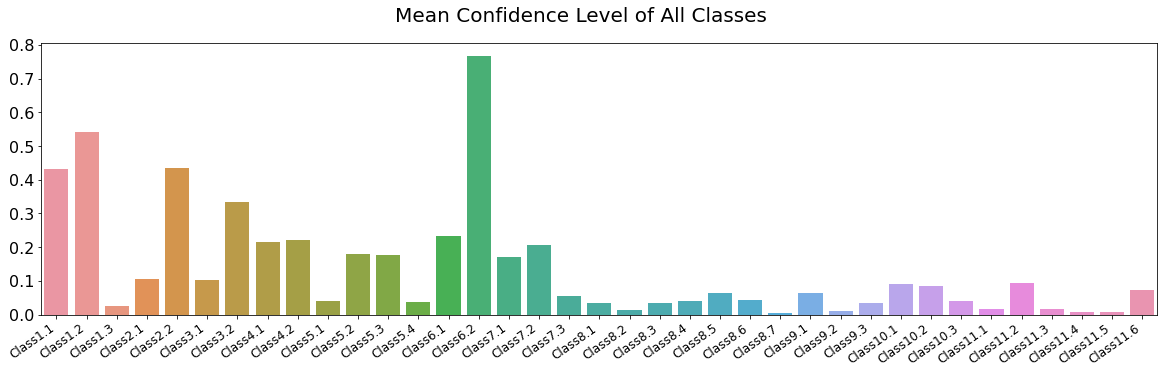

In [ ]:
title = 'Mean Confidence Level of All Classes'
plt.figure(title, figsize=(20, 5))
plt.suptitle(title, fontsize=20)
sns.barplot(x= labels.drop('GalaxyID', axis=1, inplace=False).mean().index, 
            y = labels.drop('GalaxyID', axis=1, inplace=False).mean().values)
plt.yticks(fontsize=16)
plt.xticks(fontsize=12, rotation=35, ha='right')
plt.savefig(FIGS+'all_class_confidence.pdf')
plt.show()

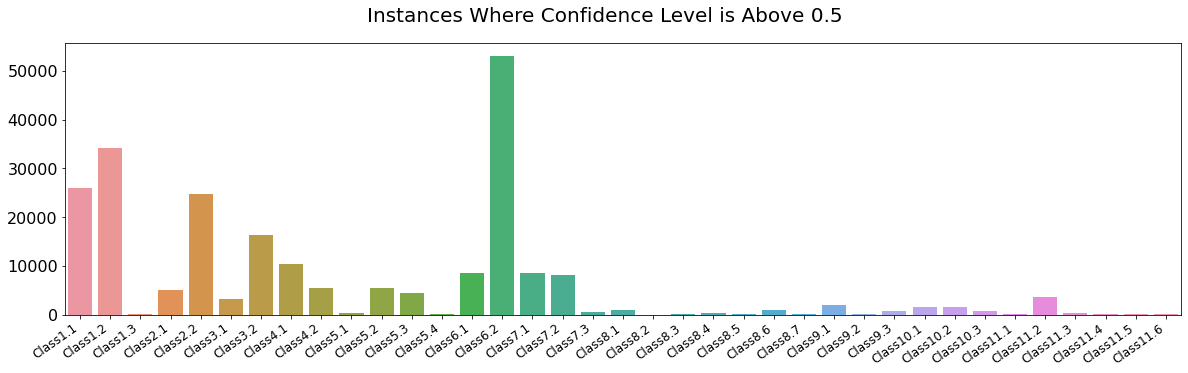

In [ ]:
title = 'Instances Where Confidence Level is Above 0.5'
plt.figure(title, figsize=(20, 5))
plt.suptitle(title, fontsize=20)
sns.barplot(x= labels.columns[1:] ,
            y = np.where(labels.drop('GalaxyID', axis=1, inplace=False).to_numpy() >= 0.5, 1, 0).sum(axis=0))
plt.yticks(fontsize=16)
plt.xticks(fontsize=12, rotation=35, ha='right')
plt.savefig(FIGS+'all_class_instances.pdf')
plt.show()

In [ ]:
terminals = [2,14,18,19,20,21,22,23,24]
print("Sum of instances of terminal classes where the confidence level is above 0.5.\n")
for n,v in zip([labels.columns[i+1] for i in terminals], [np.where(labels.drop('GalaxyID', axis=1, inplace=False).to_numpy() >= 0.5, 1, 0).sum(axis=0)[i] for i in terminals] ):
  print("%s: %d" % (n,v))

Sum of instances of terminal classes where the confidence level is above 0.5.

Class1.3: 44
Class6.2: 53115
Class8.1: 886
Class8.2: 4
Class8.3: 16
Class8.4: 301
Class8.5: 202
Class8.6: 1022
Class8.7: 27


### Odd or not?

In [ ]:
odd = [np.where(labels.drop('GalaxyID', axis=1, inplace=False).to_numpy() >= 0.5, 1, 0).sum(axis=0)[i] for i in [13,14]] 
print("Odd: {:,} or {:0.1f}%".format(odd[0], 100*odd[0]/sum(odd)))
print("Not Odd: {:,} or {:0.1f}%".format(odd[1], 100*odd[1]/sum(odd)))

Odd: 8,484 or 13.8%
Not Odd: 53,115 or 86.2%


In [ ]:
# Examine rows where a given class is above a certain threshold. 
show = 5
c = 'Class' + '6.1'
t = 0.5
labels.loc[labels[c] > t].head(show)

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,Class5.1,Class5.2,Class5.3,Class5.4,Class6.1,Class6.2,Class7.1,Class7.2,Class7.3,Class8.1,Class8.2,Class8.3,Class8.4,Class8.5,Class8.6,Class8.7,Class9.1,Class9.2,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
6,100123.jpg,0.462492,0.456033,0.081475,0.000000,0.456033,0.000000,0.456033,0.000000,0.456033,0.000000,0.000000,0.456033,0.0,0.687647,0.312353,0.388158,0.074334,0.000000,0.000000,0.000000,0.000000,0.000000,0.213858,0.473789,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
8,100134.jpg,0.021834,0.976952,0.001214,0.021751,0.955201,0.313077,0.642124,0.546491,0.408711,0.160096,0.760688,0.034417,0.0,0.611499,0.388501,0.010917,0.010917,0.000000,0.000000,0.032377,0.064143,0.450225,0.000000,0.032377,0.032377,0.000000,0.000000,0.021751,0.207253,0.152044,0.187194,0.0,0.0,0.054649,0.081974,0.081974,0.327894
16,100263.jpg,0.179654,0.818530,0.001816,0.573791,0.244739,0.047326,0.197413,0.016623,0.228116,0.071098,0.067407,0.106234,0.0,0.913055,0.086945,0.000000,0.075167,0.104487,0.000000,0.019174,0.019174,0.058436,0.058436,0.757836,0.000000,0.340376,0.091809,0.141605,0.000000,0.007855,0.008768,0.0,0.0,0.000000,0.000000,0.000000,0.016623
30,100458.jpg,0.820908,0.081499,0.097593,0.000000,0.081499,0.000000,0.081499,0.000000,0.081499,0.000000,0.000000,0.081499,0.0,0.921161,0.078839,0.355112,0.465796,0.000000,0.000000,0.026714,0.081062,0.000000,0.244108,0.569277,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
34,100513.jpg,0.275971,0.700977,0.023052,0.583914,0.117063,0.000000,0.117063,0.000000,0.117063,0.043734,0.073329,0.000000,0.0,0.881950,0.118050,0.008331,0.108519,0.159121,0.025577,0.000000,0.025577,0.000000,0.104070,0.726727,0.000000,0.525522,0.058391,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000


In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))
print("The highest confidence example for each answer / Feature.")
size = 15
fig = plt.figure('Image Examples', figsize=[size,size*10/4])
#plt.suptitle("Top Image for Each Feature", fontsize=20)
plt.axis('off')
plt.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')
for i, feature in enumerate(labels.columns[1:]):
    fig.add_subplot(10, 4, i+1)
    plt.title(feature + "\n" + desc[i]) 
    plt.axis('off')
    plt.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')

    file = labels.iloc[labels[feature].idxmax()].GalaxyID
    img = plt.imread(DATA + file, format='jpg')
    plt.imshow(img, aspect='auto')
    #plt.xlabel(str(i))
fig.tight_layout(pad=1.0)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

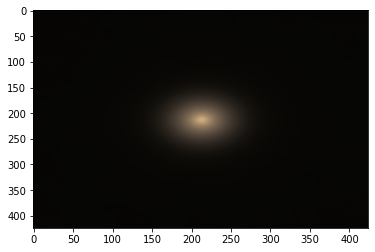

In [ ]:
arr = np.array([ plt.imread(DATA + pic, format='jpg') for pic in labels.GalaxyID[0:5000]])
plt.imshow(np.average(arr, axis=0).astype(int), aspect='auto')
plt.savefig(FIGS+'stack5000.pdf')

## Benchmarking / Simple Models

### Split the data

In [ ]:
X, X_val, y, y_val = train_test_split(labels.GalaxyID, 
                                labels[labels.columns[1:]],  
                                test_size = 0.20, 
                                random_state = RANDOM  
                                )
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,  
                                                    test_size = 0.20, 
                                                    random_state = RANDOM
                                                    )

print("Training set: %d" % X_train.shape[0])
print("Testing set: %d" % X_test.shape[0])
print("Validation set: %d" % X_val.shape[0])

Training set: 39409
Testing set: 9853
Validation set: 12316


### Evaluation

In [ ]:
# ig = image_generator(X_train, batch_size=3000)
# init = False

# for step in ig: 
#     if not init:
#         centers_train = center_pixel(step)
#         init = True; 
#     else:
#         centers_train = np.append(centers_train, center_pixel(step), axis=0)
# save(centers_train, 'centers_train.p')
# save(centers_train, 'centers_train.csv')

In [ ]:
ig = image_generator(X_test, batch_size=3000)
init = False
for step in ig: 
    if not init:
        centers_test = center_pixel(step)
        init = True; 
    else:
        centers_test = np.append(centers_test, center_pixel(step), axis=0)

save(centers_test, 'centers_test.csv')
# save(centers_test, 'centers_test.p')

In [ ]:
print(centers_train.shape)
print(centers_test.shape)

In [ ]:
ig = image_generator(X_train, batch_size=3000)
init = False
averages_train = 0
for step in ig: 
    if not init:
        averages_train = average_color(step)
        init = True; 
    else:
        averages_train = np.append(averages_train, average_color(step), axis=0)

save(averages_train, 'averages_train.csv')
save(averages_train, 'averages_train.p')

In [ ]:
ig = image_generator(X_test, batch_size=3000)
init = False
averages_test = 0
for step in ig: 
    if not init:
        averages_test = average_color(step)
        init = True; 
    else:
        averages_test = np.append(averages_test, average_color(step), axis=0)

save(averages_test, 'averages_test.csv')
save(averages_test, 'averages_test.p')

In [ ]:
print(averages_train.shape)
print(averages_test.shape)

In [ ]:
centers_train = load('centers_train.p')
centers_test = load('centers_test.p')
averages_train = load('averages_train.p')
averages_test = load('averages_test.p')

### Linear Regression

#### Center

In [ ]:
lr = LinearRegression()
lr.fit(centers_train, y_train)
pred = lr.predict(centers_test)
print("The RMSE is %.4f" % RMSE(pred, y_test))

#### Averages

In [ ]:
lr = LinearRegression()
lr.fit(averages_train, y_train)
pred = lr.predict(averages_test)
print("The RMSE is %.4f" % RMSE(pred, y_test))

#### Sanity check

In [ ]:
print("The RMSE is %.4f" % RMSE(
                                np.broadcast_to(
                                    np.array(labels[labels.columns[1:]].mean()), 
                                    (labels.shape[0], labels.shape[1]-1)
                                ), np.array(labels[labels.columns[1:]]))
)

## Building the Model

### Preprocessing

In [ ]:
%%capture

for image in labels.GalaxyID:
    
    im = cv2.imread(DATA + image)
    im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY) 
    # I read the docs and found this uses human perception of luminance already. 
    ret, thresh = cv2.threshold(im, 25, 255, 0) 
    # The numbers are upper and lower thresholds
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    ROI = (0,0,0,0) # Region of interest
    ROI_area = 0
    for contour in contours: # cv.RETR_LIST exports contrours as a list. 
        x, y, width, height = cv2.boundingRect(contour)
        area = width * height 
        if area > ROI_area:
            ROI_area = area 
            ROI = (x,y,width,height) 
    
    x, y, width, height = ROI

    if width > height:
        crop = im[y:y+width,x:x+width]
    else: 
        crop = im[y:y+height,x:x+height]

    image = image.replace('jpg','png') # I don't want to multiple the compression loss. meme.jpg.jpg.jpg 
    
    # 64x64 
    cv2.imwrite(
        DIR_64 + image, # OpenCV adheres to file extension formats 
        cv2.resize(crop, (64,64), interpolation=cv2.INTER_AREA)
    )

    # 128x128 
    cv2.imwrite(
        DIR_128 + image, 
        cv2.resize(crop, (128,128), interpolation=cv2.INTER_AREA)
    )
  

In [ ]:
!zip -r -j '/content/64.zip' '/content/processed_64x64/'
!cp '64.zip' '/content/gdrive/MyDrive/Colab Notebooks/Chia-Lin/Results/'
!zip -r -j '/content/128.zip' '/content/processed_128x128/'
!cp '128.zip' '/content/gdrive/MyDrive/Colab Notebooks/Chia-Lin/Results/'

In [ ]:
%%capture

padding_size = 0.2

for image in labels.GalaxyID:

    im = cv2.imread(DATA + image)
    im2 = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY) 
    # I read the docs and found this uses human perception of luminance already. 
    ret, thresh = cv2.threshold(im2, 10, 255, 0) 
    # The numbers are upper and lower thresholds
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    ROI = (0,0,0,0) # Region of interest
    ROI_area = 0
    for contour in contours: # cv.RETR_LIST exports contrours as a list. 
        x, y, width, height = cv2.boundingRect(contour)
        area = width * height 
        if area > ROI_area:
            ROI_area = area 
            ROI = (x,y,width,height) 
    
    x, y, width, height = ROI

    if width > height:
        pad = int(width * padding_size)
    else:
        pad = int(height * padding_size)
    
    if (y-pad >= 0 and 
        x-pad >= 0 and 
        y + max(width, height) + pad < im.shape[1] and 
        x + max(width, height) + pad < im.shape[0]):

        crop = im[y-pad:y+max(width,height)+pad,x-pad:x+max(width,height)+pad]
    else:
        crop = im
    
    image = image.replace('jpg','png') # I don't want to multiple the compression loss. meme.jpg.jpg.jpg 


    # 64x64 
    cv2.imwrite(
        
        DIR_64_WIDE + image, # OpenCV adheres to file extension formats 
        cv2.resize(crop, (64,64), interpolation=cv2.INTER_AREA)
    )

    # 128x128 
    cv2.imwrite(
        DIR_128_WIDE + image, 
        cv2.resize(crop, (128,128), interpolation=cv2.INTER_AREA)
    )

In [ ]:
!zip -r -j '/content/64_WIDE.zip' '/content/processed_64x64_WIDE/'
!cp '64_WIDE.zip' '/content/gdrive/MyDrive/Colab Notebooks/Chia-Lin/Results/'

!zip -r -j '/content/128_WIDE.zip' '/content/processed_128x128_WIDE/'
!cp '128_WIDE.zip' '/content/gdrive/MyDrive/Colab Notebooks/Chia-Lin/Results/'

In [ ]:
%%capture

padding_size = 0.2

for image in test_labels.GalaxyID:

    im = cv2.imread(TEST + image)
    im2 = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY) 
    # I read the docs and found this uses human perception of luminance already. 
    ret, thresh = cv2.threshold(im2, 10, 255, 0) 
    # The numbers are upper and lower thresholds
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    ROI = (0,0,0,0) # Region of interest
    ROI_area = 0
    for contour in contours: # cv.RETR_LIST exports contrours as a list. 
        x, y, width, height = cv2.boundingRect(contour)
        area = width * height 
        if area > ROI_area:
            ROI_area = area 
            ROI = (x,y,width,height) 
    
    x, y, width, height = ROI

    if width > height:
        pad = int(width * padding_size)
    else:
        pad = int(height * padding_size)
    
    if (y-pad >= 0 and 
        x-pad >= 0 and 
        y + max(width, height) + pad < im.shape[1] and 
        x + max(width, height) + pad < im.shape[0]):

        crop = im[y-pad:y+max(width,height)+pad,x-pad:x+max(width,height)+pad]
    else:
        crop = im
    
    image = image.replace('jpg','png') # I don't want to multiple the compression loss. meme.jpg.jpg.jpg 


    # 64x64 
    cv2.imwrite(
        
        DIR_TEST_64_WIDE + image, # OpenCV adheres to file extension formats 
        cv2.resize(crop, (64,64), interpolation=cv2.INTER_AREA)
    )

In [ ]:
!zip -r -j '/content/64_WIDE.zip' '/content/tested_64x64_WIDE/'
!cp '64_WIDE.zip' '/content/gdrive/MyDrive/Colab Notebooks/Chia-Lin/Results/64_WIDE_TEST.zip'

# !zip -r -j '/content/128_WIDE.zip' '/content/processed_128x128_WIDE/'
# !cp '128_WIDE.zip' '/content/gdrive/MyDrive/Colab Notebooks/Chia-Lin/Results/'

### Explore the processed images

<IPython.core.display.Javascript object>

### The highest confidence example for each answer / feature - 64x64 grayscale.

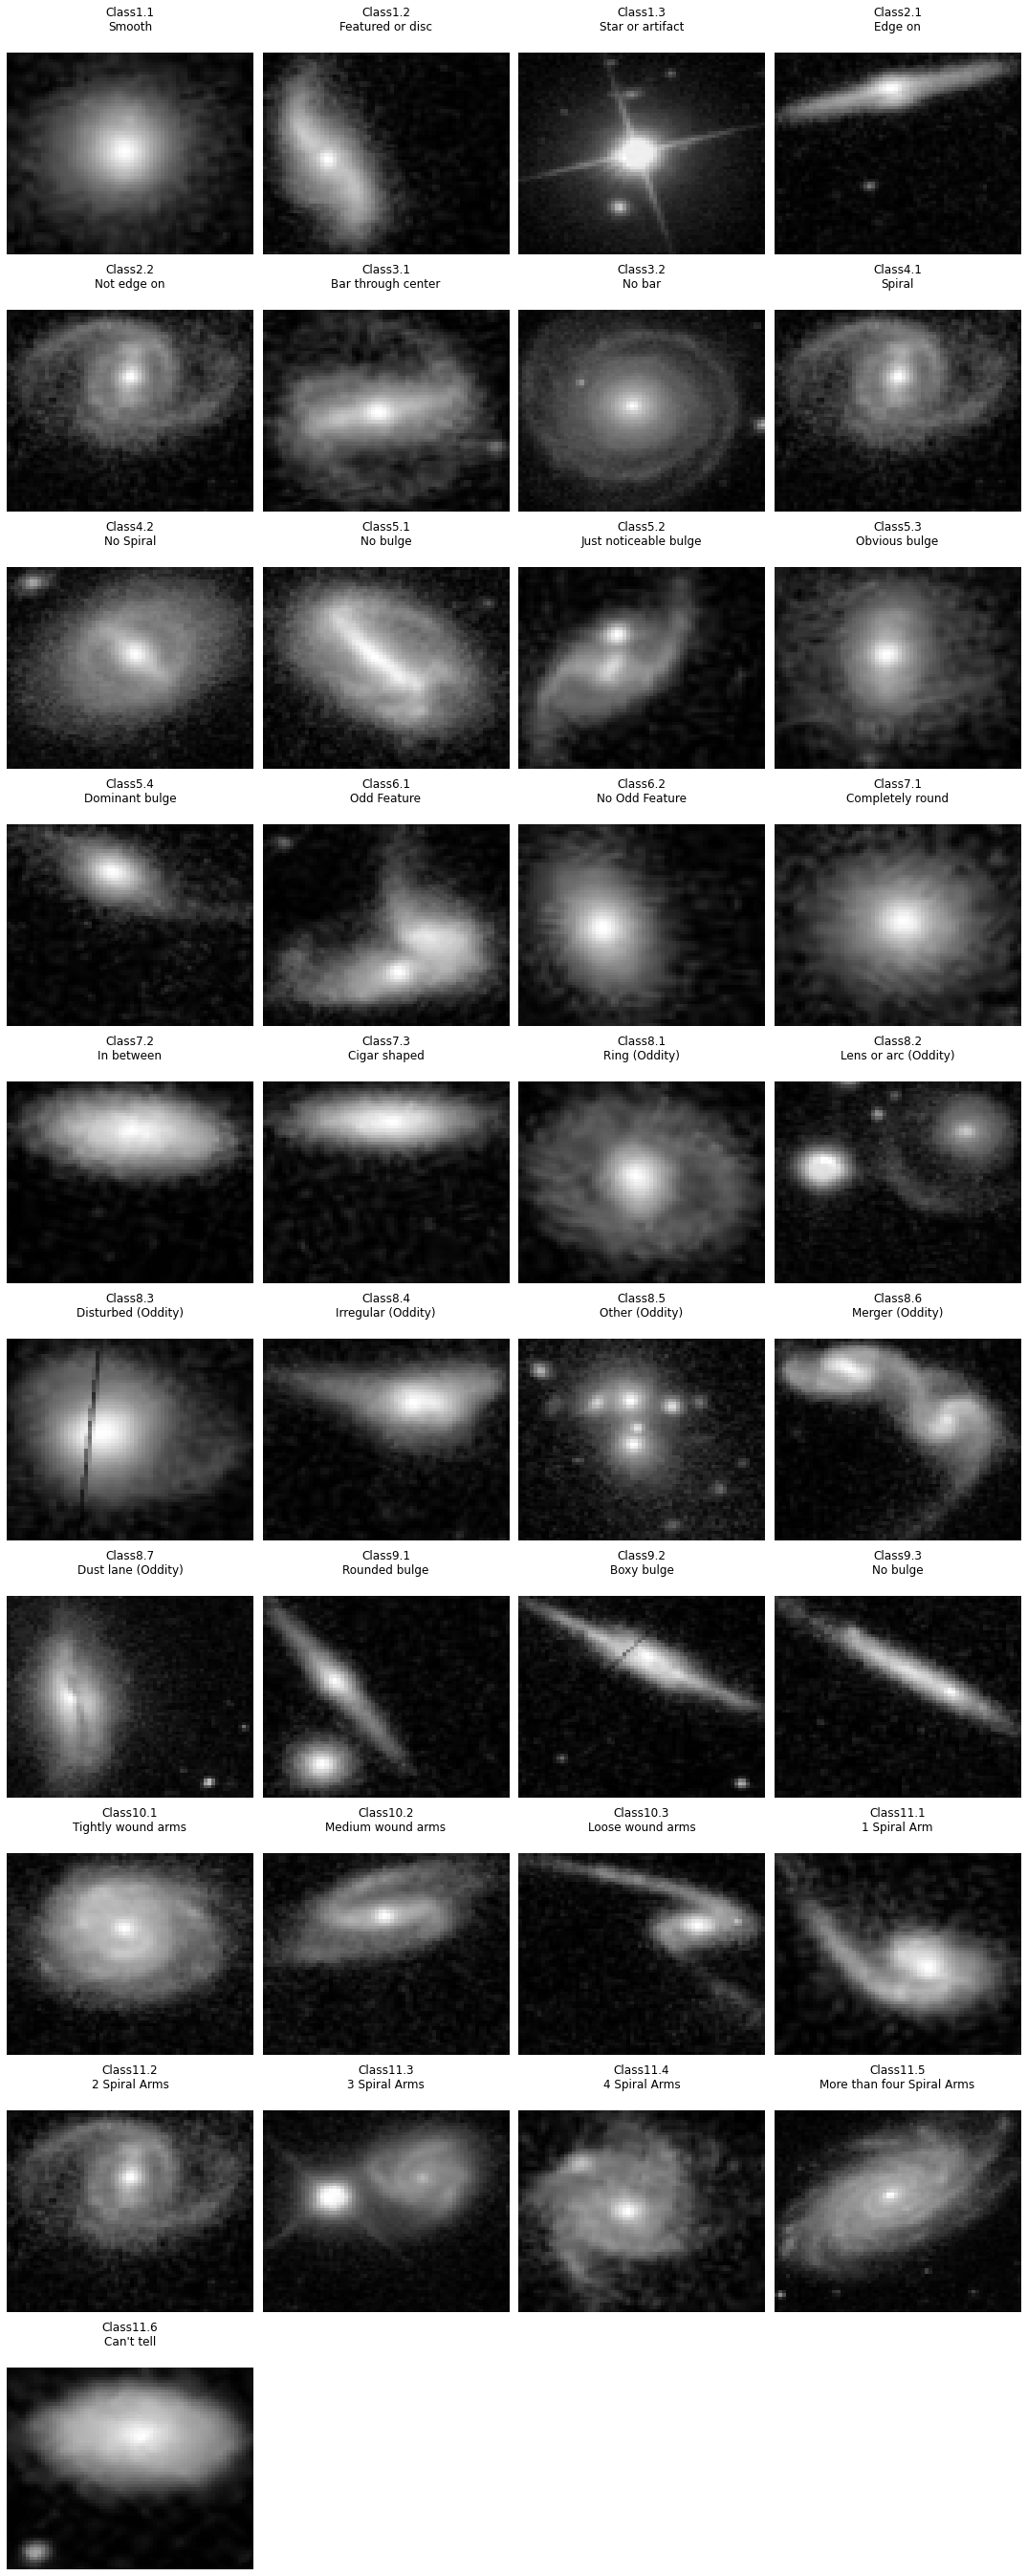

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))
display(Markdown("### The highest confidence example for each answer / feature - 64x64 grayscale."))
size = 15
fig = plt.figure('Image Examples', figsize=[size,size*10/4])
#plt.suptitle("Top Image for Each Feature", fontsize=20)
plt.axis('off')
plt.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')
for i, feature in enumerate(labels.columns[1:]):
    fig.add_subplot(10, 4, i+1)
    plt.title(feature + "\n" + desc[i]) 
    plt.axis('off')
    plt.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')

    file = labels.iloc[labels[feature].idxmax()].GalaxyID
    img = plt.imread(DIR_64 + file.replace('jpg','png'), format='jpg')
    plt.imshow(img, aspect='auto', cmap='gray')
    #plt.xlabel(str(i))
fig.tight_layout(pad=1.0)
plt.savefig(FIGS+'example_64gray.pdf')
plt.show()

<IPython.core.display.Javascript object>

### The highest confidence example for each answer / feature - 64x64 color.

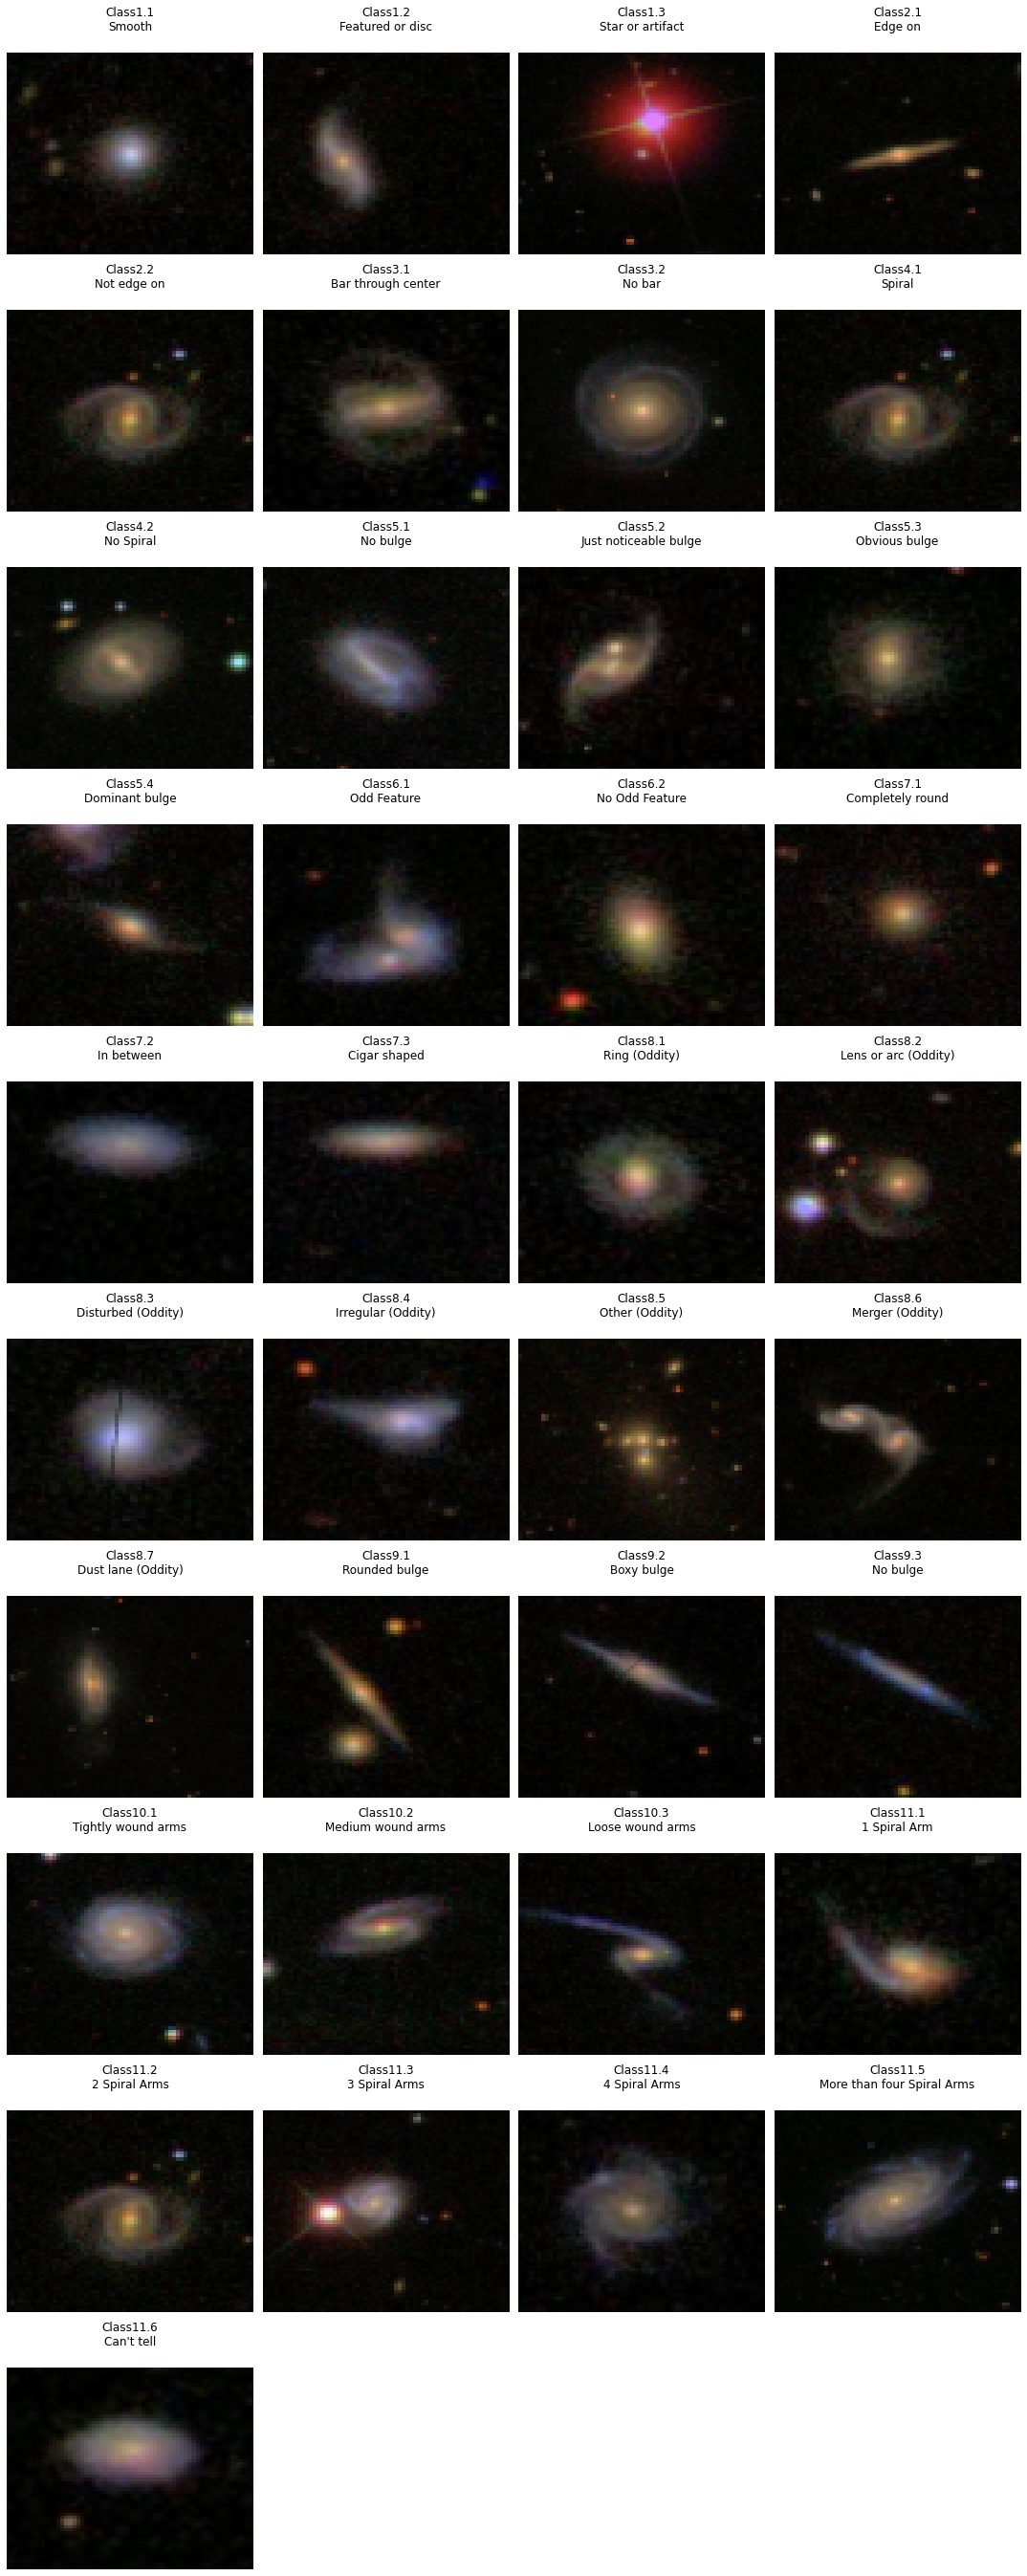

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))
display(Markdown("### The highest confidence example for each answer / feature - 64x64 color."))
size = 15
fig = plt.figure('Image Examples', figsize=[size,size*10/4])
#plt.suptitle("Top Image for Each Feature", fontsize=20)
plt.axis('off')
plt.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')
for i, feature in enumerate(labels.columns[1:]):
    fig.add_subplot(10, 4, i+1)
    plt.title(feature + "\n" + desc[i]) 
    plt.axis('off')
    plt.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')
    file = labels.iloc[labels[feature].idxmax()].GalaxyID
    img = plt.imread(DIR_64_WIDE + file.replace('jpg','png'), format='png')
    plt.imshow(img, aspect='auto', cmap='gray')
    #plt.xlabel(str(i))
fig.tight_layout(pad=1.0)
plt.savefig(FIGS+'example_64color.pdf')
plt.show()

## Convolutional Neural Network

### Setup

In [ ]:
labels = load('labels.p')

# I skipped the validation split to get more training data. In the competition, 
# the data is validated against a withheld dataset which I do not have. 

X_train, X_test, y_train, y_test = train_test_split(labels.GalaxyID.apply(lambda pic: pic.replace('jpg', 'png')), 
                                                    labels[labels.columns[1:]].to_numpy(),  
                                                    test_size = 0.20, 
                                                    random_state = RANDOM  
                                                    )

print("Training set: %d" % X_train.shape[0])
print("Testing set: %d" % X_test.shape[0])
# print("Validation set: %d" % X_val.shape[0])

def RMSE(pred, truth):
    # Element-wise RMSE score. 
    return np.sqrt( np.mean( np.square( np.array(pred).flatten() - np.array(truth).flatten() )))

Training set: 49262
Testing set: 12316


In [ ]:
!cp '/content/gdrive/MyDrive/Colab Notebooks/Chia-Lin/Results/64_WIDE.zip' '/content/64_WIDE.zip' 
!unzip '/content/64_WIDE.zip' -d '/content/processed_64x64_WIDE'

!cp '/content/gdrive/MyDrive/Colab Notebooks/Chia-Lin/Results/64_WIDE_TEST.zip' '/content/64_WIDE_TEST.zip' 
!unzip '/content/64_WIDE_TEST.zip' -d '/content/tested_64x64_WIDE'

Streaming output truncated to the last 5000 lines.
  inflating: /content/tested_64x64_WIDE/541454.png  
  inflating: /content/tested_64x64_WIDE/362005.png  
  inflating: /content/tested_64x64_WIDE/223106.png  
  inflating: /content/tested_64x64_WIDE/495554.png  
  inflating: /content/tested_64x64_WIDE/972584.png  
  inflating: /content/tested_64x64_WIDE/646843.png  
  inflating: /content/tested_64x64_WIDE/780225.png  
  inflating: /content/tested_64x64_WIDE/250742.png  
  inflating: /content/tested_64x64_WIDE/534074.png  
  inflating: /content/tested_64x64_WIDE/673301.png  
  inflating: /content/tested_64x64_WIDE/379499.png  
  inflating: /content/tested_64x64_WIDE/917804.png  
  inflating: /content/tested_64x64_WIDE/602684.png  
  inflating: /content/tested_64x64_WIDE/415534.png  
  inflating: /content/tested_64x64_WIDE/462031.png  
  inflating: /content/tested_64x64_WIDE/796174.png  
  inflating: /content/tested_64x64_WIDE/476738.png  
 extracting: /content/tested_64x64_WIDE/734140.p

In [ ]:
# Make sure they're all accounted for:
!ls -l /content/processed_64x64_WIDE/ | wc -l

61579


### Batch generator

In [ ]:
def torch_batches(pics, labels, path=DATA, batch_size=30, rotate=False, fmt='png'):
    '''
    Generate batches of PyTorch tensors from a list of image filenames.
    DATA is a global variable with the path to the image folder.  
    '''
    angles = np.array([0,90,180,270])
    labels = torch.tensor(labels, dtype=torch.float32)
    l = len(pics)
    batches = int(l/batch_size)
    leftover = l % batch_size
    for batch in range(batches):
        start = batch * batch_size
        this_batch = pics[start:start+batch_size]
        batch_labels = labels[start:start+batch_size,:]
        
        if rotate:
            yield torch.tensor([scipy.ndimage.rotate(
                                plt.imread(path + pic, format=fmt),
                                reshape=False,
                                angle=np.random.randint(0,360)
                                )
                            for pic in this_batch], dtype=torch.float32).permute(0, 3, 1, 2), batch_labels, this_batch
        else:
            yield torch.tensor([ plt.imread(path + pic, format=fmt) for pic in this_batch], dtype=torch.float32).permute(0, 3, 1, 2), batch_labels, this_batch
    start = batches * batch_size
    this_batch = pics[start:start+leftover]
    batch_labels = labels[start:start+leftover,:]
    if rotate:
        yield torch.tensor([scipy.ndimage.rotate(
                            plt.imread(path + pic, format=fmt),
                            reshape=False,
                            angle=np.random.randint(0,360)
                            )
                        for pic in this_batch], dtype=torch.float32).permute(0, 3, 1, 2), batch_labels, this_batch
    
    yield torch.tensor([ plt.imread(path + pic, format=fmt) for pic in this_batch], dtype=torch.float32).permute(0, 3, 1, 2), batch_labels, this_batch

def get_output_width(width, kernel, padding, stride):
    return int((width + 2 * padding - kernel - 1) / stride + 1)

In [ ]:
'''
Attempt 1: 

With 64x64 grayscale input achieved an RMSE of 0.17497 in 180 epochs. 
Very bad results, there's a problem with the model. 
'''

classes = labels.columns[1:]

in_width = 64 

kernel = 3
pool_kernel = 2
padding = int(kernel/2)
stride = 1 

c1_in = 1
c1_out = 8 
c1_pooled_width = get_output_width(in_width, pool_kernel, padding, pool_kernel)

c2_out = 16
c2_pooled_width = get_output_width(c1_pooled_width, pool_kernel, padding, pool_kernel)

full_1_in = c2_out * c2_pooled_width * c2_pooled_width
full_1_out = int(full_1_in / 8)
full_2_out = int(full_1_out/4)
full_3_out = len(classes)



class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        '''
        These are the layers in the network, and their attributes are the
        weights and biases of the neurons. 
        '''
        self.conv1 = nn.Conv2d(in_channels=c1_in, 
                               out_channels=c1_out, 
                               kernel_size=kernel,
                               stride=stride,
                               padding=padding,
                               padding_mode='zeros') # convolution layer, padding with zeros is convenient because the image background is black  
        self.pool = nn.MaxPool2d(2) # 2x2 kernel, stride of 2 so there's no overlap, and it's a max pooling strategy 
        self.conv2 = nn.Conv2d(in_channels=c1_out, 
                               out_channels=c2_out, 
                               kernel_size=kernel,
                               stride=stride,
                               padding=padding,
                               padding_mode='zeros') 
        # we can re-use the pooling step if the strategy stays the same 
        self.fc1 = nn.Linear(full_1_in, full_1_out)
        self.fc2 = nn.Linear(full_1_out, full_2_out)
        self.fc3 = nn.Linear(full_2_out, full_3_out)
        # self.dropout = nn.Dropout(p=0.1) # http://mipal.snu.ac.kr/images/1/16/Dropout_ACCV2016.pdf 

    def forward(self, x):
        # feed each layer into the next 
        x = self.pool(F.relu(self.conv1(x))) # first convolution 
        x = self.pool(F.relu(self.conv2(x))) # second convolution 
        x = x.view(x.size()[0],-1) # flatten output for fully connected layer 
        x = F.relu(self.fc1(x)) # Linear equation wrapped in activation function
        x = F.relu(self.fc2(x)) 
        x = self.fc3(x) # The output layer 
        return x 

net = Net()

In [ ]:
'''
Attempt 2: 

Achieved a score of 0.17411. Not good. So bad in fact that I think I've chosen 
the wrong loss function. 

Attempt 3: 

Built a custom loss function using weights based on the distribution of classes. 

Result: RMSE of 0.15994. It beats the provided central pixel benchmark, but not my own. 
Moving in the right direction, but there are still problems with the architecture. 
 
'''

classes = labels.columns[1:]

in_width = 64 

kernel = 5
pool_kernel = 2
padding = int(kernel/2)
stride = 1 

c1_in = 3
c1_kernel = 9
c1_out = 64 
c1_conv_width = get_output_width(in_width, c1_kernel, int(c1_kernel/2), stride)
c1_pooled_width = get_output_width(c1_conv_width, int(pool_kernel/2), 0, pool_kernel)

c2_kernel = 5
c2_out = 96
c2_conv_width = get_output_width(c1_pooled_width, c2_kernel, int(c2_kernel/2), stride)
c2_pooled_width = get_output_width(c2_conv_width, pool_kernel, int(pool_kernel/2), pool_kernel)

full_1_in = c2_out * c2_pooled_width * c2_pooled_width
full_1_out = int(full_1_in / 8)
full_2_out = int(full_1_out/4)
full_3_out = len(classes)


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        '''
        These are the layers in the network, and their attributes are the
        weights and biases of the neurons. 
        '''
        self.conv1 = nn.Conv2d(in_channels=c1_in, 
                               out_channels=c1_out, 
                               kernel_size=c1_kernel,
                               stride=stride,
                               padding=padding,
                               padding_mode='zeros') 
        
        self.pool = nn.MaxPool2d(pool_kernel) # 2x2 kernel, stride of 2 so there's no overlap, and it's a max pooling strategy 
        self.conv2 = nn.Conv2d(in_channels=c1_out, 
                               out_channels=c2_out, 
                               kernel_size=c2_kernel,
                               stride=stride,
                               padding=padding,
                               padding_mode='zeros') 
        self.conv2_bn = nn.BatchNorm2d(c2_out)
        # we can re-use the pooling step if the strategy stays the same 
        self.fc1 = nn.Linear(full_1_in, full_1_out)
        self.fc2 = nn.Linear(full_1_out, full_2_out)
        self.fc3 = nn.Linear(full_2_out, full_3_out)
        self.dropout = nn.Dropout(p=0.15) # http://mipal.snu.ac.kr/images/1/16/Dropout_ACCV2016.pdf 

    def forward(self, x):
        # feed each layer into the next 
        x = self.pool(F.relu(self.conv1(x))) # first convolution 
        x = self.pool(F.relu(self.conv2_bn(self.conv2(x)))) # second convolution 
        x = x.view(x.size()[0],-1) # flatten output for fully connected layer 
        x = F.relu(self.dropout(self.fc1(x))) # Linear equation wrapped in activation function
        x = F.relu(self.dropout(self.fc2(x))) 
        x = self.fc3(x) # The output layer 
        return x 

net = Net()

In [ ]:
'''
Attempt 4: 

I don't know how I missed the signmoid activation function! Probability models 
work best when their output is bound by zero and one.  

I also added an additional convolution layer. 

Result: RMSE 0.11025

YES! I beat my goal of 0.12504. I'm now 78/326 on the leaderboard. 
'''

classes = labels.columns[1:]

in_width = 64 

kernel = 5
pool_kernel = 2
padding = int(kernel/2)
stride = 1 

c1_in = 3
c1_kernel = 9
c1_out = 64 
c1_conv_width = get_output_width(in_width, c1_kernel, c1_kernel/2, stride)
c1_pooled_width = get_output_width(c1_conv_width, pool_kernel/2, 0, pool_kernel)
print("C1: ", c1_conv_width)
print('P1: ', c1_pooled_width)

c2_kernel = 5
c2_out = 96
c2_conv_width = get_output_width(c1_pooled_width, c2_kernel, c2_kernel/2, stride)
c2_pooled_width = get_output_width(c2_conv_width, pool_kernel, pool_kernel/2, pool_kernel)
print("C2: ", c2_conv_width)
print('P2: ', c2_pooled_width)

c3_kernel = 3
c3_out = 128
c3_conv_width = get_output_width(c2_pooled_width, c3_kernel, c3_kernel/2, stride)
c3_pooled_width = get_output_width(c3_conv_width, pool_kernel, pool_kernel/2, pool_kernel)
print("C3: ", c3_conv_width)
print('P3: ', c3_pooled_width)

full_1_in = c3_out * c3_pooled_width * c3_pooled_width
full_1_out = 1024
full_2_out = 256
full_3_out = len(classes)


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        '''
        These are the layers in the network, and their attributes are the
        weights and biases of the neurons. 
        '''
        self.conv1 = nn.Conv2d(in_channels=c1_in, 
                               out_channels=c1_out, 
                               kernel_size=c1_kernel,
                               stride=stride,
                               padding= int(c1_kernel/2),
                               padding_mode='zeros') 
        
        self.pool = nn.MaxPool2d(pool_kernel) # 2x2 kernel, stride of 2 so there's no overlap, and it's a max pooling strategy 
        self.conv2 = nn.Conv2d(in_channels=c1_out, 
                               out_channels=c2_out, 
                               kernel_size=c2_kernel,
                               stride=stride,
                               padding= int(c2_kernel/2),
                               padding_mode='zeros') 
        self.conv3 = nn.Conv2d(in_channels=c2_out, 
                               out_channels=c3_out, 
                               kernel_size=c3_kernel,
                               stride=stride,
                               padding= int(c3_kernel/2),
                               padding_mode='zeros') 
        self.conv2_bn = nn.BatchNorm2d(c2_out)
        self.conv3_bn = nn.BatchNorm2d(c3_out)
        # we can re-use the pooling step if the strategy stays the same 
        self.fc1 = nn.Linear(full_1_in, full_1_out)
        self.fc2 = nn.Linear(full_1_out, full_2_out)
        self.fc3 = nn.Linear(full_2_out, full_3_out)
        self.dropout = nn.Dropout(p=0.15) # randomly shut off 15% of neurons in the later  

    def forward(self, x):
        # feed each layer into the next 
        x = self.pool(F.relu(self.conv1(x))) # first convolution 
        x = self.pool(F.relu(self.conv2_bn(self.conv2(x)))) # second convolution 
        x = self.pool(F.relu(self.conv3_bn(self.conv3(x))))
        x = x.view(x.size()[0],-1) # flatten output for fully connected layer 
        x = F.relu(self.dropout(self.fc1(x))) # Linear equation wrapped in activation function
        x = F.relu(self.dropout(self.fc2(x))) # 
        x = F.sigmoid(self.fc3(x)) # The output layer 
        return x 

net = Net()

C1:  64
P1:  32
C2:  32
P2:  16
C3:  16
P3:  8


### Training the Network

In [ ]:
loss_weight = torch.tensor(np.sum(y_train, axis=0) / np.sum(y_train))

def weighted_mse_loss(output, targets, weights):
    loss = (output - targets) ** 2
    loss = loss * weights.expand(loss.shape) # broadcast (37,) weight array to (n, 37). 
    loss = loss.mean(0)
    return loss.sum()

# optimizer = optim.SGD(net.parameters(), lr=0.0005, momentum=0.7)
optimizer = optim.Adam(net.parameters()) # Adam should converge faster than stochastic gradient descent

loss_history = []
batch_size = 1024 
mini_batch_size = 64 
display("Start")

for epoch in range(1,6): 
    batch_no = 1

    datagen = torch_batches(X_train, 
                        y_train, 
                        path=DIR_64_WIDE,
                        batch_size=batch_size,
                        rotate=True)
    
    for images, targets, _ in datagen: # big read from storage
        for mini_batch in range(int(batch_size/mini_batch_size)):
            start = mini_batch*mini_batch_size
            if start >= images.shape[0]:
                break
            finish = start + mini_batch_size
            optimizer.zero_grad()   
            outputs = net(images[start:finish])
            loss = weighted_mse_loss(outputs, targets[start:finish], loss_weight)
            loss.backward()
            optimizer.step()
        clear_output()
        display("Epoch %d, batch %d - loss: %.5f" % (epoch, batch_no, loss.item()))
        batch_no += 1
        loss_history.append((epoch, batch_no, loss.item()))

save(net, 'net_4.p')
save_txt(str(net), SAVE +'net_4.txt')
torch.save(net, 'net_t_4.p')
save(optimizer, 'optim_4.p')
save_txt(str(optimizer), SAVE +'net_4.txt')
save(loss_history, 'hist_4.p')
save_csv(np.array(loss_history), 'hist_4.csv')

'Epoch 5, batch 50 - loss: 0.01863'

### Evaluating the trained model's performance

In [ ]:
datagen = torch_batches(X_test, 
                    y_test, 
                    path=DIR_64_WIDE,
                    batch_size=1000)

pred = np.empty((0,len(classes)), float)

for images, targets, pics in datagen:
    outputs = net(images)
    pred = np.append(pred, outputs.detach().numpy(), axis=0)

save_csv(pred, 'pred.csv')
RMSE(y_test, pred)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0.11327401621485439

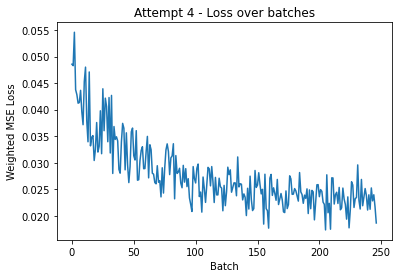

In [ ]:
import matplotlib.pyplot as plt 
title = "Attempt 4 - Loss over batches"
plt.title(title)
plt.xlabel('Batch')
plt.ylabel('Weighted MSE Loss')
plt.plot([error[2] for error in loss_history[3:]])
plt.savefig(FIGS +'loss.pdf')
plt.show()

In [ ]:
X_test.shape

(12316,)